In [1]:
import os
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
import torch
import tqdm
import platform
import shutil
import json
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
import yaml

# https://github.com/facebookresearch/deit/blob/7e160fe43f0252d17191b71cbb5826254114ea5b/datasets.py#L108
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Michelle
data_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/"
model_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/models/"
if platform.node() == 'navi': # Daniel
    data_prefix = "/home/argon/Stuff/CSE244A_project/"
    model_prefix = "/home/argon/Stuff/CSE244A_project/models/"

In [3]:
categories = pd.read_csv(os.path.join(data_prefix, 'categories.csv'))
train_labels = pd.read_csv(os.path.join(data_prefix, 'train_labeled.csv'))

In [4]:
def save_config(conf):
    with open(conf["model_name"] + ".yaml", 'w') as f:
        yaml.dump(conf, f)

def load_config(conf_name):
    with open(conf_name + ".yaml", 'r') as f:
        return yaml.safe_load(f)

In [5]:
# Someday this should probably be some yaml files... - Daniel

#TODO: Add batch size to this
#TODO: Add model type (e.g. facebookresearch/deit:main)

# training_config = {
#     "model_name":  "michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4",
#     "optimizer_type": "AdamW",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "scheduler_type": "ReduceLROnPlateau",
#     "scheduler_params": {"factor": 0.1,
#                          "patience": 0,
#                          "threshold": 0.0},
#     "unfreeze_layers": ['blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }
# save_config(training_config)
# training_config = load_config("michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4")

# training_config = load_config("michelle_diet_imagenetmean__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4")
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

# training_config = {
#     "model_name":  "michelle_diet_imagenetmean_augmentD__freeze10__explr_1en4_0.8__AdamW_wdecay_1en4",
#     "optimizer_type": "AdamW",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "augment_mode": "augmentD",
#     "scheduler_type": "ExponentialLR",
#     "scheduler_params": {"gamma": 0.8,},
#     "unfreeze_layers": ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }
# save_config(training_config)
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze10__explr_1en4_0.8__AdamW_wdecay_1en4")

# Reproduce the best one?
training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

training_config

{'augment_mode': 'augmentD',
 'model_name': 'michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4',
 'optimizer_lr': 0.0001,
 'optimizer_type': 'AdamW',
 'optimizer_wd': 0.0001,
 'scheduler_params': {'gamma': 0.8},
 'scheduler_type': 'ExponentialLR',
 'unfreeze_layers': ['blocks.11.norm1.weight',
  'blocks.11.norm1.bias',
  'blocks.11.attn.qkv.weight',
  'blocks.11.attn.qkv.bias',
  'blocks.11.attn.proj.weight',
  'blocks.11.attn.proj.bias',
  'blocks.11.norm2.weight',
  'blocks.11.norm2.bias',
  'blocks.11.mlp.fc1.weight',
  'blocks.11.mlp.fc1.bias',
  'blocks.11.mlp.fc2.weight',
  'blocks.11.mlp.fc2.bias',
  'norm.weight',
  'norm.bias',
  'head.weight',
  'head.bias']}

In [6]:
def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler=None):
    checkpoint_dict = {
        "epoch": epoch,
        "model_dict": model.state_dict(),
        "optimizer_dict": optimizer.state_dict(),
    }
    
    # Consistently name the scheduler key as "scheduler_dict"
    if scheduler:
        checkpoint_dict["scheduler_dict"] = scheduler.state_dict()

    torch.save(checkpoint_dict, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_dict"])

    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_dict"])
    
    # Consistently access the scheduler as "scheduler_dict"
    if scheduler and "scheduler_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_dict"])
        
    return checkpoint["epoch"]

class TrainingHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def save(self, history_path):
        with open(history_path, "w", encoding="utf-8") as f:
            json.dump({
                "train_loss": self.train_loss,
                "val_loss": self.val_loss,
                "train_acc": self.train_acc,
                "val_acc": self.val_acc,
            }, f)

    def load(self, history_path):
        with open(history_path, "r", encoding="utf-8") as f:
            hist = json.load(f)
        self.train_loss = hist["train_loss"]
        self.val_loss = hist["val_loss"]
        self.train_acc = hist["train_acc"]
        self.val_acc = hist["val_acc"]

    def append(self, train_loss, val_loss, train_acc, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

    def is_best(self):
        """Return true if the last epoch added is the best seen so far"""
        return all([self.val_loss[-1] < i for i in self.val_loss[:-1]])

In [7]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, label_csv=None, return_filenames=False, transform=None):
        self.label_values = None
        self.return_filenames = return_filenames
        if label_csv is not None:
            csv_data = pd.read_csv(label_csv)
            self.filenames = csv_data["image"].tolist()
            self.label_values = csv_data["id"].tolist()
        else:
            self.filenames = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        result = [image]

        if self.label_values is not None:
            result.append(self.label_values[idx])

        if self.return_filenames:
            result.append(self.filenames[idx])

        return result


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std as needed
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [9]:
if not "augment_mode" in training_config:
    augmented_transform = transform
else:
    if training_config["augment_mode"] == "augment":
        # Data augmentation https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
        augmented_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
                    transforms.RandomErasing(p=0.2, value='random')
                ])
    elif training_config["augment_mode"] == "augmentD":
        # Less augmented
        augmented_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
                ])
    else:
        raise RuntimeError("Unknown augmentation")
    augmented_transform

In [10]:
# Initialize datasets
train_dataset = ImageDataset(os.path.join(data_prefix,'train/labeled'), label_csv=os.path.join(data_prefix,'train_labeled.csv'), transform=augmented_transform)
val_dataset = ImageDataset(os.path.join(data_prefix,'train/labeled'), label_csv=os.path.join(data_prefix,'train_labeled.csv'), transform=transform)
# unlabeled_dataset = ImageDataset(os.path.join(data_prefix,'train/unlabeled'), transform=augmented_transform)

# Training / validation split
val_ratio = 0.1
batch_size = 16

val_size = int(val_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size

generator1 = torch.Generator().manual_seed(12341234)
# Generate as indices so we can save them if needed, but I'm not doing that yet - Daniel
val_idx, train_idx = torch.utils.data.random_split(torch.arange(len(train_dataset)), [val_size, train_size], generator=generator1)
train =  torch.utils.data.Subset(train_dataset, train_idx)
val =  torch.utils.data.Subset(val_dataset, val_idx)

labeled_train_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
labeled_val_data = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)


In [11]:
# # TODO: Ensure train/val is well split along class lines
# train_classes = [i[1] for i in train]
# val_classes = [i[1] for i in val]

# print(torch.unique(torch.as_tensor(train_classes),return_counts=True))
# print(torch.unique(torch.as_tensor(val_classes),return_counts=True))

# torch.unique(torch.as_tensor(train_classes)) == torch.unique(torch.as_tensor(val_classes))

Labeled images:


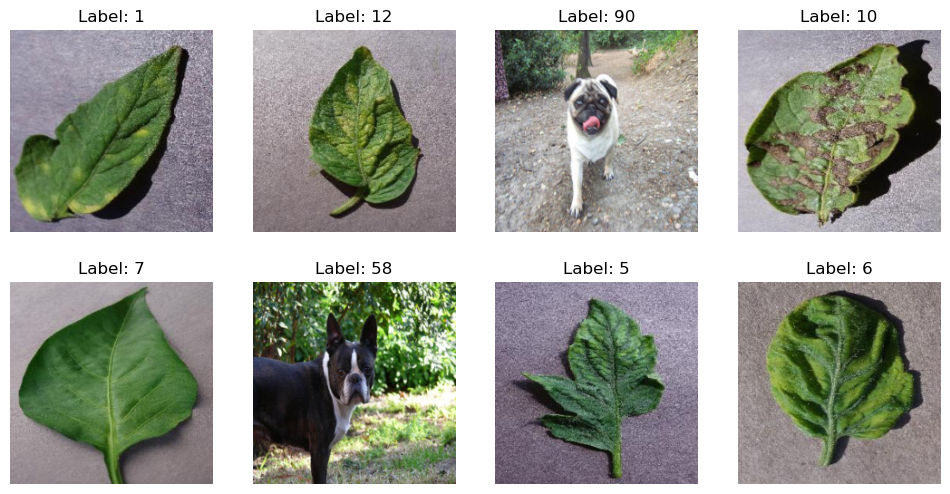

In [12]:
# Function to display a batch of labeled images with labels
def show_labeled_batch(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        # https://stackoverflow.com/questions/65676151/how-does-torchvision-transforms-normalize-operate
        img = (img * torch.as_tensor(IMAGENET_DEFAULT_STD)) + torch.as_tensor(IMAGENET_DEFAULT_MEAN)
        plt.imshow(img)
        plt.title(f'Label: {labels[idx].item()}')
        plt.axis('off')
    plt.show()

# Function to display a batch of unlabeled images
def show_unlabeled_batch(data_loader):
    images = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = (img * torch.as_tensor(IMAGENET_DEFAULT_STD)) + torch.as_tensor(IMAGENET_DEFAULT_MEAN)
        plt.imshow(img)
        plt.title("Unlabeled Image")
        plt.axis('off')
    plt.show()

# Display a batch of labeled images
print("Labeled images:")
show_labeled_batch(labeled_train_data)
pass

# # Display a batch of unlabeled images
# print("Unlabeled images:")
# show_unlabeled_batch(unlabeled_loader)


In [13]:
# https://pytorch.org/tutorials/beginner/vt_tutorial.html
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cache found in /home/argon/.cache/torch/hub/facebookresearch_deit_main
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/argon/.cache/torch/hub/facebookresearch_deit_main/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @regis

In [14]:
# Modify the final layer to match the number of classes
num_classes = len(categories)  # Adjust to the actual number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

In [15]:
# https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to(device)
if not "optimizer_type" in training_config or training_config["optimizer_type"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
elif training_config["optimizer_type"] == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
else:
    raise NotImplementedError()
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)


In [16]:
def freeze_by_list(model, unfrozen):
    # https://stackoverflow.com/questions/62523912/freeze-certain-layers-of-an-existing-model-in-pytorch
    total_unfrozen = 0
    for name, param in model.named_parameters():
        if name in unfrozen:
            total_unfrozen += 1
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

if "unfreeze_layers" in training_config:
    freeze_by_list(model, training_config["unfreeze_layers"])

[(i[0], i[1].requires_grad) for i in model.named_parameters()]

[('cls_token', False),
 ('pos_embed', False),
 ('patch_embed.proj.weight', False),
 ('patch_embed.proj.bias', False),
 ('blocks.0.norm1.weight', False),
 ('blocks.0.norm1.bias', False),
 ('blocks.0.attn.qkv.weight', False),
 ('blocks.0.attn.qkv.bias', False),
 ('blocks.0.attn.proj.weight', False),
 ('blocks.0.attn.proj.bias', False),
 ('blocks.0.norm2.weight', False),
 ('blocks.0.norm2.bias', False),
 ('blocks.0.mlp.fc1.weight', False),
 ('blocks.0.mlp.fc1.bias', False),
 ('blocks.0.mlp.fc2.weight', False),
 ('blocks.0.mlp.fc2.bias', False),
 ('blocks.1.norm1.weight', False),
 ('blocks.1.norm1.bias', False),
 ('blocks.1.attn.qkv.weight', False),
 ('blocks.1.attn.qkv.bias', False),
 ('blocks.1.attn.proj.weight', False),
 ('blocks.1.attn.proj.bias', False),
 ('blocks.1.norm2.weight', False),
 ('blocks.1.norm2.bias', False),
 ('blocks.1.mlp.fc1.weight', False),
 ('blocks.1.mlp.fc1.bias', False),
 ('blocks.1.mlp.fc2.weight', False),
 ('blocks.1.mlp.fc2.bias', False),
 ('blocks.2.norm1.weig

In [17]:
# lr scheduler
if "scheduler_type" in training_config:
    if training_config["scheduler_type"] == "StepLR":
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ExponentialLR":
        lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **training_config["scheduler_params"])
else:
    lr_scheduler = None
print(lr_scheduler)

In [18]:
model_path = os.path.join(model_prefix, training_config["model_name"])
os.makedirs(model_path, exist_ok=True)

In [19]:
num_epochs = 20  # Adjust as needed

In [ ]:
model.to(device)
start_epoch = 0
hist = TrainingHistory()

checkpoint_path = os.path.join(model_path, "checkpoint.pth")
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, lr_scheduler, device=device)
    hist.load(os.path.join(model_path, "history.json"))

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for images, labels in tqdm.tqdm(labeled_train_data, desc=f"Train ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

        
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for images, labels in tqdm.tqdm(labeled_val_data, desc=f"Validation ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track statistics
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()
    
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler.step(val_loss)
    elif lr_scheduler:
        lr_scheduler.step()

    hist.append(train_loss/train_total, val_loss/val_total, train_correct/train_total, val_correct/val_total)
    
    tmp_checkpoint_path = os.path.join(model_path, f"checkpoint-{epoch}.pth")
    save_checkpoint(tmp_checkpoint_path, epoch + 1, model, optimizer, lr_scheduler)
    shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"checkpoint.pth"))
    if hist.is_best():
        shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"checkpoint-best.pth"))
    os.unlink(tmp_checkpoint_path)

    hist.save(os.path.join(model_path, "history.json"))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/train_total:.6f}, Val Loss: {val_loss/val_total:.6f}")
    print(f"      Train Accuracy: {100 * train_correct/train_total:.2f}%, Val Accuracy: {100 * val_correct/val_total:.2f}%")
    print(f"      New LR={[g['lr'] for g in optimizer.param_groups]}")


Validation (1/20): 100%|██████████| 62/62 [00:01<00:00, 37.89it/s]


Epoch [1/20], Train Loss: 0.113326, Val Loss: 0.066315
      Train Accuracy: 78.11%, Val Accuracy: 93.60%
      New LR=[8e-05]


Validation (2/20): 100%|██████████| 62/62 [00:01<00:00, 39.76it/s]


Epoch [2/20], Train Loss: 0.059656, Val Loss: 0.063046
      Train Accuracy: 97.11%, Val Accuracy: 94.62%
      New LR=[6.400000000000001e-05]


Validation (3/20): 100%|██████████| 62/62 [00:01<00:00, 39.73it/s]


Epoch [3/20], Train Loss: 0.055839, Val Loss: 0.062105
      Train Accuracy: 98.94%, Val Accuracy: 95.63%
      New LR=[5.120000000000001e-05]


Validation (4/20): 100%|██████████| 62/62 [00:01<00:00, 38.76it/s]


Epoch [4/20], Train Loss: 0.054194, Val Loss: 0.061674
      Train Accuracy: 99.47%, Val Accuracy: 96.04%
      New LR=[4.0960000000000014e-05]


Validation (5/20): 100%|██████████| 62/62 [00:01<00:00, 39.64it/s]


Epoch [5/20], Train Loss: 0.053386, Val Loss: 0.061697
      Train Accuracy: 99.73%, Val Accuracy: 96.04%
      New LR=[3.2768000000000016e-05]


Validation (6/20): 100%|██████████| 62/62 [00:01<00:00, 40.14it/s]


Epoch [6/20], Train Loss: 0.052809, Val Loss: 0.061494
      Train Accuracy: 99.85%, Val Accuracy: 96.04%
      New LR=[2.6214400000000015e-05]


Validation (7/20): 100%|██████████| 62/62 [00:01<00:00, 40.24it/s]


Epoch [7/20], Train Loss: 0.052503, Val Loss: 0.061636
      Train Accuracy: 99.88%, Val Accuracy: 96.04%
      New LR=[2.0971520000000012e-05]


Validation (8/20): 100%|██████████| 62/62 [00:01<00:00, 40.40it/s]


Epoch [8/20], Train Loss: 0.052272, Val Loss: 0.061549
      Train Accuracy: 99.90%, Val Accuracy: 96.04%
      New LR=[1.677721600000001e-05]


Validation (9/20): 100%|██████████| 62/62 [00:01<00:00, 40.36it/s]


Epoch [9/20], Train Loss: 0.052098, Val Loss: 0.061552
      Train Accuracy: 99.92%, Val Accuracy: 96.35%
      New LR=[1.3421772800000009e-05]


Validation (10/20): 100%|██████████| 62/62 [00:01<00:00, 40.64it/s]


Epoch [10/20], Train Loss: 0.051964, Val Loss: 0.061628
      Train Accuracy: 99.91%, Val Accuracy: 96.14%
      New LR=[1.0737418240000008e-05]


Validation (11/20): 100%|██████████| 62/62 [00:01<00:00, 40.16it/s]


Epoch [11/20], Train Loss: 0.051884, Val Loss: 0.061709
      Train Accuracy: 99.91%, Val Accuracy: 96.24%
      New LR=[8.589934592000007e-06]


Validation (12/20): 100%|██████████| 62/62 [00:01<00:00, 40.26it/s]


Epoch [12/20], Train Loss: 0.051807, Val Loss: 0.061674
      Train Accuracy: 99.92%, Val Accuracy: 96.24%
      New LR=[6.871947673600007e-06]


Validation (13/20): 100%|██████████| 62/62 [00:01<00:00, 40.04it/s]


Epoch [13/20], Train Loss: 0.051737, Val Loss: 0.061707
      Train Accuracy: 99.92%, Val Accuracy: 96.14%
      New LR=[5.4975581388800055e-06]


Validation (14/20): 100%|██████████| 62/62 [00:01<00:00, 40.08it/s]


Epoch [14/20], Train Loss: 0.051691, Val Loss: 0.061699
      Train Accuracy: 99.93%, Val Accuracy: 96.14%
      New LR=[4.3980465111040045e-06]


Validation (15/20): 100%|██████████| 62/62 [00:01<00:00, 40.25it/s]


Epoch [15/20], Train Loss: 0.051647, Val Loss: 0.061719
      Train Accuracy: 99.94%, Val Accuracy: 96.14%
      New LR=[3.5184372088832037e-06]


Validation (16/20): 100%|██████████| 62/62 [00:01<00:00, 40.37it/s]


Epoch [16/20], Train Loss: 0.051616, Val Loss: 0.061806
      Train Accuracy: 99.93%, Val Accuracy: 96.14%
      New LR=[2.8147497671065632e-06]


Validation (17/20): 100%|██████████| 62/62 [00:01<00:00, 40.54it/s]


Epoch [17/20], Train Loss: 0.051596, Val Loss: 0.061817
      Train Accuracy: 99.93%, Val Accuracy: 96.14%
      New LR=[2.2517998136852508e-06]


Validation (18/20): 100%|██████████| 62/62 [00:01<00:00, 40.16it/s]


Epoch [18/20], Train Loss: 0.051583, Val Loss: 0.061801
      Train Accuracy: 99.92%, Val Accuracy: 96.14%
      New LR=[1.8014398509482006e-06]


Validation (19/20): 100%|██████████| 62/62 [00:01<00:00, 40.41it/s]


Epoch [19/20], Train Loss: 0.051560, Val Loss: 0.061799
      Train Accuracy: 99.93%, Val Accuracy: 96.24%
      New LR=[1.4411518807585606e-06]


Validation (20/20): 100%|██████████| 62/62 [00:01<00:00, 40.42it/s]


Epoch [20/20], Train Loss: 0.051541, Val Loss: 0.061875
      Train Accuracy: 99.98%, Val Accuracy: 96.14%
      New LR=[1.1529215046068486e-06]


Text(0.5, 0, 'Epoch')

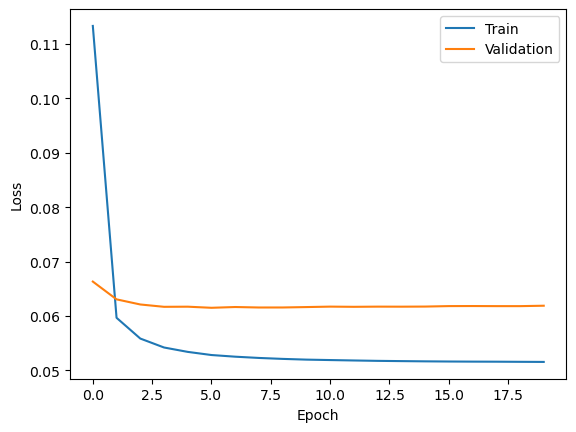

In [21]:
# Plot Loss
plt.plot(range(len(hist.train_loss)), hist.train_loss, label="Train")
plt.plot(range(len(hist.val_loss)), hist.val_loss, label="Validation")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

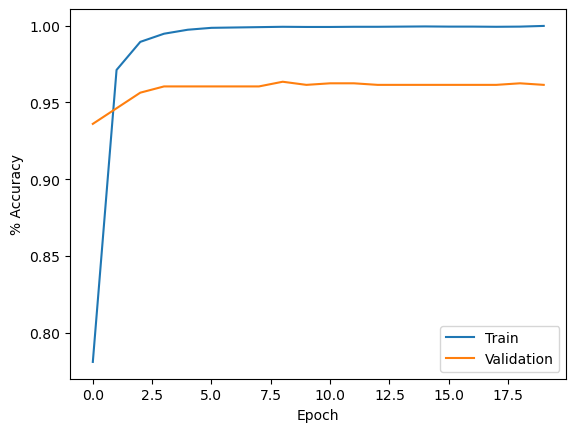

In [22]:
# Plot Accuracy
plt.plot(range(len(hist.train_acc)), hist.train_acc, label="Train")
plt.plot(range(len(hist.val_acc)), hist.val_acc, label="Validation")
plt.legend()
plt.ylabel("% Accuracy")
plt.xlabel("Epoch")

In [23]:
raise "STOP"

TypeError: exceptions must derive from BaseException

In [24]:
test_dataset = ImageDataset(root_dir=os.path.join(data_prefix,'test'), return_filenames=True, transform=transform)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)

In [25]:
import csv

def create_csv_with_number(base_name, data):
    """Creates a CSV file with a unique number in the filename if the file already exists."""

    file_number = 1
    file_name = f"{base_name}.csv"

    while os.path.exists(file_name):
        file_name = f"{base_name}_{file_number}.csv"
        file_number += 1

    # Save to CSV
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["image", "id"])  # Write header
        writer.writerows(data)  # Write predictions

    print(f"File '{file_name}' created and results saved successfully.")

In [26]:
hist = None
best_checkpoint_path = os.path.join(model_path, "checkpoint-best.pth")
best_epoch = load_checkpoint(best_checkpoint_path, model, optimizer, lr_scheduler, device=device)
print(best_checkpoint_path)
print("Best epoch:", best_epoch)

model.to(device)
model.eval()
results = []

with torch.no_grad():
    for images, filenames in tqdm.tqdm(test_data, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get the predicted class IDs

        # Store filename and predicted label
        results.extend(zip(filenames, predicted.cpu().numpy()))

create_csv_with_number("test_submission", results)

/tmp/ipykernel_328310/2032433435.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


/home/argon/Stuff/CSE244A_project/models/michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-best.pth
Best epoch: 6


Testing: 100%|██████████| 514/514 [00:12<00:00, 40.41it/s]

File 'test_submission_9.csv' created and results saved successfully.
